## 算法简介

目标检测是现有的最常见的计算机视觉任务之一，其目标是在给定的图片中精确找到物体所在位置，同时标注出物体的类别。所以，object detection的核心在于如何构建这个能同时输出坐标和类别的系统。  

目前学术和工业界出现的目标检测算法分成3类：
1. 传统的目标检测算法：Cascade + HOG/DPM + Haar/SVM以及上述方法的诸多组合、优化版本。

2. 候选区域/窗 + 深度学习分类：通过提取候选区域，并对相应区域进行以深度学习方法为主的分类的方案，如：  
  R-CNN（Selective Search + CNN + SVM）  
  SPP-net（ROI Pooling）  
  Fast R-CNN（Selective Search + CNN + ROI）  
  Faster R-CNN（RPN + CNN + ROI）  

3. 基于深度学习的回归方法：YOLO/SSD/DenseBox 等方法；以及最近出现的结合RNN算法的RRC detection；结合DPM的Deformable CNN等

其中二三两类属于深度学习的应用，而RCNN是第二种算法的开山之作，其核心思想直接引导了后续算法的产生。  

## 一、实验目的

1. 理解RCNN整体逻辑 分类+定位
2. 理解RCNN提取候选框的方式：selective search
3. 理解RCNN最终对bounding box进行回归的方法

## 二、实验步骤

** 1.获取trainfiles和valfiles，用于模型训练和模型验证 **

In [4]:
import glob

#采用原始数据的trainval用于网络训练，其余数据用于网络验证
trainvalpath = './VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt'#segmentation分割数据划分
trainval = []#训练数据
with open(trainvalpath, 'r') as f:
    while True:
        line = f.readline()     # 逐行读取
        if not line:
            break
        trainval.append(line.replace("\n",""))

AnnotationsPath = "./VOCdevkit/VOC2012/Annotations/"
all_files = glob.glob(AnnotationsPath + "*.xml")

#以list形式进行存储，每个item包含两个值：imgfile_path, segmentation_path
trainfiles = []
valfiles = []
for file in all_files:
    name = file.split('/')[-1].split('.xml')[0]#获取文件名称
    if name in trainval:
        trainfiles.append(file)
    else:
        valfiles.append(file)

print("trainfiles is {} and valfiles is {}".format(len(trainfiles), len(valfiles)))

trainfiles is 11540 and valfiles is 5585


** 2.解析pascal数据，获取fine-tune的数据样本 **

** 2.1 构建selective search方法 （样本生成依赖此方法）**

In [5]:
"""
Created on Sat Dec 29 13:09:50 2018

@author: yanjie.lv
用于从原图中生成一系列候选框，数量为2000
"""

import skimage.data
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy
import matplotlib.patches as mpatches
import cv2
from PIL import Image


def _generate_segments(im_orig, scale, sigma, min_size):
    """
    生成预分割区域
    """
    # 根据felzenszwalb算法生成预分割区域蒙版
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)

    # 将蒙版添加到图片的第四通道
    im_orig = numpy.append(
        im_orig, numpy.zeros(im_orig.shape[:2])[:, :, numpy.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask
    return im_orig

def _calc_colour_hist(img):
    """
        计算每个区域的颜色直方图
    """
    BINS = 25
    hist = numpy.array([])
    for colour_channel in (0, 1, 2):
        # 提取单一颜色通道
        c = img[:, colour_channel]
        # 计算每个颜色的直方图然后合并结果
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(c, BINS, (0.0, 255.0))[0]])
    # 归一化
    hist = hist / len(img)
    return hist

def _calc_texture_hist(img):
    """
        计算每个区域的纹理直方图
    """
    BINS = 10
    hist = numpy.array([])
    for colour_channel in (0, 1, 2):
        #按照颜色标记通道
        fd = img[:, colour_channel]
        #计算每个方向的直方图，再合并这个结果
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(fd, BINS, (0.0, 1.0))[0]])
    # 归一化
    hist = hist / len(img)
    return hist


def _calc_texture_gradient(img):
    """
        计算整张图的纹理梯度
    """
    ret = numpy.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret

def _extract_regions(img):
    '''
        提取特征区域
    '''
    R = {}
    # 从rgb转换到hsv
    hsv = skimage.color.rgb2hsv(img[:, :, :3])
    # 1. 对每个像素进行识别
    for y, i in enumerate(img):
        # 除了rgb三通道 第四通道储存分类结果
        for x, (r, g, b, l) in enumerate(i):
            # 初始化
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    # 2.计算纹理梯度
    tex_grad = _calc_texture_gradient(img)

    # 3.计算每个区域的特征直方图
    for k, v in list(R.items()):
        # 颜色直方图
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)
        # 纹理直方图
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R

def _extract_neighbours(regions):
    '''
        提取相邻区域
    '''
    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False
    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))
    return neighbours


def _sim_colour(r1, r2):
    """
        计算直方图相关颜色的数量和
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])

def _sim_texture(r1, r2):
    """
        计算直方图相关纹理的数量和
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        计算图片尺寸相似度
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        计算图片区域吻合度
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize

def _calc_sim(r1, r2, imsize):
    '''
        计算无权重下综合相似度
    '''
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))


def _merge_regions(r1, r2):
    '''
        合并区域
    '''
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt

def selective_search(
        im_orig, scale=1.0, sigma=0.8, min_size=50):
    '''
        selective_search主函数调用
    '''
    assert im_orig.shape[2] == 3, "3ch image is expected"

    #区域标签储存在第四通道，[r,g,b,(region)]
    img = _generate_segments(im_orig, scale, sigma, min_size)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    R = _extract_regions(img)

    # 提取局部信息
    neighbours = _extract_neighbours(R)

    # 计算初始相似度
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize)

    # 层级搜索
    while S != {}:

        # 按相似度排序
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # 合并相关区域
        t = max(R.keys()) + 1.0
        R[t] = _merge_regions(R[i], R[j])

        # 标记待删除区域
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # 删除标记区域
        for k in key_to_delete:
            del S[k]

        # 计算新区域的相似度数值
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize)

    regions = []
    for k, r in list(R.items()):
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })
    return img, regions#返回的是多通道图（四通道）和得到的

def region_proposal_own(img, proposals):
    '''
    img采用opencv读取
    region proposal生成调用接口(自己实现)
    对生成的候选框进行后处理，删除识别相同区域以及小区域
    :param proposals: 生成的候选框个数
    '''
    img_lbl, regions = selective_search(img, scale=500, sigma=0.9, min_size=10)#这个参数在库函数中未发现
    candidates = set()
    
    for i, r in enumerate(regions):
        if i == proposals:
            break#候选框数量符合要求，则停止迭代
        # 删除相同识别区域
        if r['rect'] in candidates:
            continue
        # 删除过小识别区域
        if r['size'] < 2000:
            continue    
        # 将识别区域转换成矩形候选框
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])
    
    return candidates#最终获取的框

def region_proposal_cv(img, proposals):
    '''
    img采用opencv读取
    region proposal 生成调用接口(库函数)
    保留2000个proposal
    '''
    #分割器
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    #设定分割图形
    ss.setBaseImage(im)
    #快速模式
    ss.switchToSelectiveSearchFast()
    #实行分割
    rects = ss.process()
    #后续处理   
    candidates = set()
    for i, r in enumerate(rects):
        if i == proposals:
            break        
        r = tuple(r)
        x,y,w,h = r
        size = w*h

        # 删除相同识别区域
        if r in candidates:
            continue
        # 删除过小识别区域，这个阈值有点。。。
        if size < 2000:
            continue
        # 将识别区域转换成矩形候选框
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r)
    
    return candidates

** 2.2 fine-tune数据生成 ** 

In [6]:
import multiprocessing
import glob
import os
import cv2
import random
import pandas
import pickle
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
    
def parse_xml(xml_path):
    '''
    xml文件解析，得到相关类别，并存储bbox信息
    '''
    
    #read xml
    tree = ET.ElementTree(file=xml_path)
    
    result = {}#存放key: file_path, value: label, boundingbox
    #要生成的信息
    #initializer
    result['filepath'] = ""
    result['object'] = {}#存放object, key: label, value: bbox
    Object = {}

    for elem in tree.getroot(): 
        if elem.tag == "filename":
            filename = elem.text
            result['filepath'] = "./VOCdevkit/VOC2012/JPEGImages/"+filename  
        if elem.tag == "object":
            for child in elem:
                if child.tag == "name":
                    label = child.text
                    if label not in Object.keys():
                        Object[label] = []#初始化
                if child.tag == "bndbox":
                    xmin = 0
                    ymin = 0
                    xmax = 0
                    ymax = 0
                    for child_box in child:
                        if child_box.tag == "xmin":
                            xmin = float(child_box.text)
                        if child_box.tag == "xmax":
                            xmax = float(child_box.text)
                        if child_box.tag == "ymin":
                            ymin = float(child_box.text)
                        if child_box.tag == "ymax":
                            ymax = float(child_box.text)
                    Object[label].append([xmin, ymin, xmax, ymax])
    result['object'] = Object
    return result 

def all_annotations_get(xml_files, result):
    '''
    多进程进行pascal数据解析
    ''' 
    pool = multiprocessing.Pool(processes=8)#4个进程，根据机器性能而定
    for xml_file in xml_files:
        result.append(pool.apply_async(parse_xml, (xml_file, )))
    pool.close()
    pool.join()

def positive_data_get(all_data):
    '''
    只包含positive data
    数据处理成fine_tune data_generate易于处理的形式
    存储形式：dict形式， key: label, string;  value: ['filepath', rects(list)], list;
    '''
    #获取所有的label
    
    positive_data = {}#用于进行迭代器的数据，以annotation label为单位
    for item in all_data:#k: filepath, value: labels
        file_path = item['filepath']
        Object = item['object']
        for label in Object.keys():#label, rects
            if label not in positive_data:
                positive_data[label]=[]#initializer
            rects = Object[label]
            for rect in rects:#框
                item = [file_path, rect]
                positive_data[label].append(item)
    return positive_data#用于抽样

def negative_data_get_thread(data, thres = 0.3):
    '''
    单数据处理
    '''
    negative_rects = []
    
    file_path = data['filepath']
    Object = data['object']
    
    #获取所有的positive rect
    positive_rects = []
    for label in Object.keys():
        positive_rects = positive_rects + Object[label]
    
    #selective search生成proposal
    img = cv2.imread(file_path)
    proposals = region_proposal_own(img, 2000)#生成候选区域，返回结果是set集合
    #计算每个候选区域和positive rect的IOU，如果均小于0.3，则该区域是negative rects
    for proposal in proposals:#proposal:(x,y,w,h)
        max_IOU = 0#保留最大的IOU
        for rect in positive_rects:# rect:(xmin, ymin, xmax, ymax)
            IOU = calcIOU(proposal, (rect[0], rect[1], rect[2]-rect[0], rect[3]-rect[1]))
            if IOU > max_IOU:
                max_IOU = IOU
        if max_IOU < thres:#negative rect
            #保存当前图像的负类proposal
            negative_rects.append([file_path, [proposal[0], proposal[1], proposal[0]+proposal[2], proposal[1]+proposal[3]]])#xmin, ymin, xmax, ymax
    
    #如果negative_rects超过5个元素，随机挑选5个负样本
    if len(negative_rects)>5:
        slice = random.sample(negative_rects, 5)
        return slice
    else:
        return negative_rects

def negative_samples_with_multiple_thread(all_data, result):
    '''
    多进程处理list数据
    '''
    pool = multiprocessing.Pool(processes=8)#6个进程
    for data in all_data:
        result.append(pool.apply_async(negative_data_get_thread, (data, )))
    pool.close()
    pool.join()

def calcIOU(proposal, positive_rect):
    (one_x, one_y, one_w, one_h)=proposal
    (two_x, two_y, two_w, two_h)=positive_rect
    
    if((abs(one_x - two_x) < ((one_w + two_w) / 2.0)) and (abs(one_y - two_y) < ((one_h + two_h) / 2.0))):
        lu_x_inter = max((one_x - (one_w / 2.0)), (two_x - (two_w / 2.0)))
        lu_y_inter = min((one_y + (one_h / 2.0)), (two_y + (two_h / 2.0)))

        rd_x_inter = min((one_x + (one_w / 2.0)), (two_x + (two_w / 2.0)))
        rd_y_inter = max((one_y - (one_h / 2.0)), (two_y - (two_h / 2.0)))

        inter_w = abs(rd_x_inter - lu_x_inter)
        inter_h = abs(lu_y_inter - rd_y_inter)

        inter_square = inter_w * inter_h
        union_square = (one_w * one_h) + (two_w * two_h) - inter_square

        calcIOU = inter_square / union_square * 1.0
    else:
        calcIOU=0
    
    return calcIOU
    
def pos_neg_data_comp(xml_files):
    '''
    生成fine-tune数据调用接口
    xml_files:要解析的数据列表
    '''
    
    result = []#最终存储的是pool对象
    all_annotations_get(xml_files, result)
    #get data
    data = []
    for res in result:
        data.append(res.get())
    
    final_data = positive_data_get(data)#保存得到的所有数据
    
    negative_result = []#存储运行的pool对象，用于获取结果
    negative_samples_with_multiple_thread(data, negative_result)
    negative_data = []
    for res in negative_result:
        negative_data = negative_data + res.get()
    #将negative data作为background一类
    
    final_data['background'] = negative_data
    
    return final_data

traindata = pos_neg_data_comp(trainfiles)#获取所有数据，存储为dict格式
valdata = pos_neg_data_comp(valfiles)

#print
print("-----------traindata---------------")
for key in traindata:
    print(key, len(traindata[key]))
print("-----------valdata-----------------")
for key in valdata:
    print(key, len(valdata[key]))

/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorco

-----------traindata---------------
person 10129
pottedplant 1099
boat 999
chair 2906
dog 1541
tvmonitor 826
bottle 1482
cat 1227
bus 637
sheep 994
car 2364
cow 702
motorbike 751
bicycle 790
aeroplane 954
sofa 786
diningtable 747
train 656
bird 1221
horse 750
background 40633
-----------valdata-----------------
person 7272
diningtable 53
bicycle 47
bird 50
horse 53
chair 150
pottedplant 103
boat 60
cat 50
cow 69
bus 48
motorbike 50
sofa 55
dog 57
tvmonitor 67
car 128
aeroplane 48
bottle 79
train 48
sheep 90
background 23418


** 3.基于生成的数据样本对ResNet50进行fine-tune，构建目标检测的分类系统 **

** 3.1 生成数据标签  background类别为0，其余按需标注 **

In [91]:
#基于traindata定义标签
def label_define(data):
    label = {}
    i = 1
    for key in data.keys():
        if key == "background":
            label[key]=0    #background类设置为0
        else:
            label[key] = i
            i+=1
    return label

all_labels = label_define(traindata)
print(all_labels)

{'person': 1, 'pottedplant': 2, 'boat': 3, 'chair': 4, 'dog': 5, 'tvmonitor': 6, 'bottle': 7, 'cat': 8, 'bus': 9, 'sheep': 10, 'car': 11, 'cow': 12, 'motorbike': 13, 'bicycle': 14, 'aeroplane': 15, 'sofa': 16, 'diningtable': 17, 'train': 18, 'bird': 19, 'horse': 20, 'background': 0}


** 3.2 将valdata由dict形式转换为list形式，方便后续处理 **

In [19]:
#将val_data转换为list形式，方便后续处理
def data_transform(val_data):
    '''
    val_data是dict格式
    将dict格式转换为list形式
    主要目的用于构建generator
    '''
    data_list = []
    for key in val_data.keys():
        for filepath, rect in val_data[key]:
            data_list.append([key, filepath, rect])#存放
    return data_list

valdata['person'] = random.sample(valdata['person'], 100)
valdata['background'] = random.sample(valdata['background'], 100)#acc评价指标更准确

val_data = data_transform(valdata)#list形式[key, filepath, rect]
print(len(val_data))

1505


** 3.3 train_generator和val_generator定义，其中，train_generator需要对数据平衡进行处理 **

In [20]:
def load_traindata(batch_list, labels, img_size):
    '''
    基于batch_list加载数据  key: file_list
    :param batch_list: 获取的batch list, 字典
    :param labels: 数据全局标签
    :param img_size: 模型加载的数据大小
    '''
    batch_data = []
    batch_label = []
    for key in batch_list.keys():
        file_list = batch_list[key]#当前类的file_list
        label = labels[key]#当前所有数据的标签
        for item in file_list:
            filepath = item[0]
            rect = item[1]
            xmin, ymin, xmax, ymax = rect
            
            #transform to int
            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)
            
            img = cv2.imread(filepath)
            sub_img = img[ymin:ymax, xmin:xmax,:]#获取子图
            #sub_img = cv2.resize(sub_img, (img_size, img_size))#将图像resize到目标尺寸
            sub_img = preprocess(sub_img, img_size)
            batch_data.append(sub_img)
            batch_label.append(label)#加载标签
    
    batch_data = np.array(batch_data)
    batch_label = np.array(batch_label)
    
    #shuffle data
    index =  list(range(batch_data.shape[0]))
    random.shuffle(index)
    batch_data = batch_data[index]
    batch_label = batch_label[index]
    return batch_data, batch_label

def traindata_generator(train_data, labels, batch_label = 64, batch_size = 128, img_size = 224):
    '''
    用于网络中batch 数据生成
    暂时不加入数据增强方法
    考虑到batch内部进行数据平衡，通过有放回抽样模拟
    :param train_data: 训练数据集，字典格式，key值为label, value为对应label的list数据，list格式[filepath, rect]
    :param labels: 获取的数据全局标签, 字典格式，key值为label， value为int值，对应标签数据
    :param batch_label: batch_size数据包含的label数目
    参数要求： batch_size > batch_label
    '''
    label = list(train_data.keys())#获取类别数据
    #求取真实batch_label个数
    batch_label = min(batch_label, len(label))#两者取其小，样本抽样
    number_samples = int(batch_size // batch_label)#每一类的抽样数目，需要保证batch_size大于类别个数
    label_samples = batch_label-1#从中抽取len(label)-1个数目抽取number_samples个数据，最后一类获取batch_size - number_samples * (len(label)-1)个数据样本
    
    while True:
        keys = random.sample(label, label_samples)
        batch_list = {}#字典简单

        #数据抽样
        #存储格式：key, file_list
        for key in label:
            batch_list[key] = []#初始化空集
            if key in keys:#这部分样本抽取数目为number_samples
                #如果直接抽取片段，对于小的数据样本不利          
                for i in range(number_samples):
                    batch_list[key] = batch_list[key] + random.sample(train_data[key], 1)#抽取一个样本
            else:
                number_samples2 = batch_size - number_samples * label_samples
                for i in range(number_samples2):
                    batch_list[key] = batch_list[key] + random.sample(train_data[key], 1)

        Xbatch, Ybatch = load_traindata(batch_list, labels, img_size)
        yield Xbatch, Ybatch

def valdata_generator(val_data, labels, batch_size = 128, img_size = 224):
    '''
    初始版本的generator出现错误
    '''
    while True:
        random.shuffle(val_data)
        for i in range(len(val_data)//batch_size):
            batch_list = val_data[i*batch_size:(i+1)*batch_size]
            Xbatch, Ybatch = load_valdata(batch_list, labels, img_size)
            yield Xbatch, Ybatch

def load_valdata(batch_list, labels, img_size):
    
    Xbatch = []
    Ybatch = []
    
    for item in batch_list:
        label_name = item[0]
        filepath = item[1]
        xmin, ymin, xmax, ymax = item[2]
        
        #transform to int
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        label = labels[label_name]
        img = cv2.imread(filepath)
        sub_img = img[ymin:ymax, xmin:xmax,:]
        sub_img = preprocess(sub_img, img_size)
        Xbatch.append(sub_img)
        Ybatch.append(label)
    
    return np.array(Xbatch), np.array(Ybatch)

def preprocess(img, img_size):
    '''
    对图像数据进行预处理
    包含两步：resize && normal
    img: 原图, bgr图
    img_size: 图像目标size
    '''
    #resize
    img = cv2.resize(img, (img_size, img_size))
    #normal
    mean = [103.939, 116.779, 123.68]#去均值
    for i in range(3):
        img[i,:,:]= img[i,:,:] - mean[i]
    #img = img / 255.0 #归一化
    return img

train_gen = traindata_generator(traindata, all_labels, batch_size = 128)#traindata generator
val_gen = valdata_generator(val_data, all_labels, batch_size = 32)#validation generator 

** 3.4 构建ResNet50模型 **

In [12]:
from keras.applications.resnet50 import ResNet50
import keras

#构建model
model = ResNet50(include_top=False, weights='imagenet', input_shape = (224, 224, 3))#用于fine-tune object detection
#cnn model output
x = model.output
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = keras.layers.Dense(len(all_labels), activation='softmax', name='fc')(x)
model = keras.models.Model(inputs=model.input, outputs = x, name='resnet50-fune-tune')

/usr/local/SkyCompute/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


** 3.5 设置模型参数 **

In [13]:
#层的锁定
for layer in model.layers:
    if layer.name == "res5a_branch2a":
        break#寻找到当前层
    else:
        layer.trainable = False#层锁定

#compile
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

#train过程相关信息
callbacks = [keras.callbacks.ModelCheckpoint('./rcnn.h5', monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
             keras.callbacks.TensorBoard(log_dir='./logs')]#动态调节学习率，日志存储

** 3.6 模型训练 **

In [21]:
import numpy as np

model.fit_generator(generator=train_gen,
                    steps_per_epoch=1000,
                    epochs=100,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_gen,
                    validation_steps=(len(val_data)//32))

Epoch 1/100
1000/1000 [==============================] - 447s 447ms/step - loss: 1.4352 - acc: 0.6126 - val_loss: 1.0352 - val_acc: 0.7094
Epoch 2/100
1000/1000 [==============================] - 439s 439ms/step - loss: 0.7024 - acc: 0.8024 - val_loss: 0.8287 - val_acc: 0.7480
Epoch 3/100
1000/1000 [==============================] - 440s 440ms/step - loss: 0.5478 - acc: 0.8414 - val_loss: 0.7533 - val_acc: 0.7626
Epoch 4/100
1000/1000 [==============================] - 439s 439ms/step - loss: 0.4614 - acc: 0.8653 - val_loss: 0.7095 - val_acc: 0.7786
Epoch 5/100
1000/1000 [==============================] - 439s 439ms/step - loss: 0.4006 - acc: 0.8836 - val_loss: 0.6848 - val_acc: 0.7826
Epoch 6/100
1000/1000 [==============================] - 438s 438ms/step - loss: 0.3533 - acc: 0.8988 - val_loss: 0.6670 - val_acc: 0.7932
Epoch 7/100
1000/1000 [==============================] - 439s 439ms/step - loss: 0.3100 - acc: 0.9143 - val_loss: 0.6578 - val_acc: 0.7959
Epoch 8/100
1000/1000 [====

** 4. 将训练好的rcnn.h5模型进行重构，模型输出包含两部分：分类结果和avg_pool输出的特征向量 **

In [22]:
"""
@author: yanjie.lv
修改模型输出，使得regression数据生成时，可以同时返回预测标签以及特征向量
"""
import keras

initial_model = keras.models.load_model('./rcnn.h5')
#获取globalaveragepooling层输出的feature
for layer in initial_model.layers:
    if layer.name == "avg_pool":
        output_tensor2=layer.output
        break

output_tensor1 = initial_model.output

model_transform = keras.models.Model(inputs = initial_model.input, outputs = [output_tensor1, output_tensor2], name="feature_extract")
model_transform.load_weights('./rcnn.h5')

keras.models.save_model(model_transform, './feature_extract.h5')

** 5. bounding box 回归 **

** 5.1 将数据处理成[filepath, {label, rect}],用于循环生成regression数据 **

In [26]:
def data_process(all_data):
    '''
    将数据处理成{filepath, {label, rect}}格式，方便后续处理
    '''
    result = {}
    for key, value in all_data.items():
        if key == 'background':
            continue
        for filepath, rect in value:#file_path, rect
            if filepath not in result:
                result[filepath] = {}#初始化
            if key not in result[filepath]:
                result[filepath][key] = []#value初始化
            result[filepath][key].append(rect)

    return result

traindata_transform = data_process(traindata)
valdata_transform = data_process(valdata)

for key in traindata_transform:
    print(key, traindata_transform[key])
    break

/SkyDiscovery/cephfs/user/yanjie.lv/skyedu_algorithm/VOCdevkit/VOC2012/JPEGImages/2008_003051.jpg {'person': [[254.0, 153.0, 279.0, 228.0]], 'pottedplant': [[361.0, 239.0, 404.0, 277.0], [108.0, 239.0, 150.0, 278.0]]}


** 5.2  生成regression数据 [P, G] **

In [50]:
#这一步涉及到对proposal的分类预测以及IOU的计算，很耗时间，可以尝试自己对其进行优化
from tqdm import tqdm

def traindata_comp(model, initial_data, all_labels, IOU_thres):
    '''
    生成regression数据
    :param model: keras classification model
    :param initial_data: 所有类别数据，存储格式： key: filepath, value: dict-> {key: label , value: rect_list}
    :param IOU_thres: 只计算与ground_truth超过一定阈值的proposal
    :param all_labels: 用于解析标签

    returns: list, item为[P, G]
    '''
    data_pair = {}#保留最终的数据对
    #基于不同类别进行
    
    filepaths = list(initial_data.keys())#用于进度条显示
    bar = tqdm(filepaths)

    for filepath in bar:
        bar.set_description("Now get {}".format(filepath.split('/')[-1]))
        gd = initial_data[filepath]
        img = cv2.imread(filepath)
        proposals = region_proposal_own(img, 2000)#候选框set集合
        #对生成的每一个proposal用classification进行预测
        result = {}#存储图片预测结果
        
        data_proposal = []
        pos_proposal = []
        for proposal in proposals:#单张图生成的proposal
            x, y, w, h = proposal

            #获取xmin, ymin, xmax, ymax
            xmin = int(x)
            ymin = int(y)
            xmax = int(x+w)
            ymax = int(y+h)

            #获取sub_img
            sub_img = img[ymin:ymax, xmin:xmax, :]
            #数据 preprocess
            sub_img = preprocess(sub_img, 224)
            data_proposal.append(sub_img)
            pos_proposal.append([xmin, ymin, xmax, ymax])
        
        if (len(data_proposal)==0):#无有效proposal
            continue
        
        pos_proposal = np.array(pos_proposal)#xmin, ymin, xmax, ymax
        data_proposal = np.array(data_proposal)
        predict_label, feature_vector = model.predict(data_proposal)
        predict_label = np.argmax(predict_label, axis=1)
        
        
        index = list(np.where(predict_label>0)[0])#获取不是背景的样本， 行列表
        
        if len(index)==0:
            continue
        
        #基于行索引获取pos和feature
        valid_pos = pos_proposal[index]#xmin, ymin, xmax, ymax
        valid_feature = feature_vector[index]
        valid_label = predict_label[index]
        
        for i in range(len(index)):
            label = valid_label[i]
            feature = valid_feature[i]
            pos = valid_pos[i]
            
            if label not in result:
                result[label] = []#初始化
            result[label].append([[pos[0], pos[1], pos[2], pos[3]], feature])
        
        #result中存放了一张图片所有的预测结果
        #同一类的数据进行
        for label in gd:
            rect_list = gd[label]
            #获取当前label对应的int value
            label_int = all_labels[label]
            #未预测出当前类
            if label_int not in result:
                continue#忽略
            predict_rects = result[label_int]#预测得到的rects以及相应的feature_vector
            for t_rect in rect_list:

                max_iou = 0 #保留最大iou proposal
                best_p = None#保留最佳proposal
                for p_rect, p_feature in predict_rects:#遍历

                    #计算IOU
                    iou = calcIOU((p_rect[0],p_rect[1], p_rect[2]-p_rect[0], p_rect[3]-p_rect[1]), (t_rect[0], t_rect[1], t_rect[2]-t_rect[0], t_rect[3]-t_rect[1]))

                    if iou < IOU_thres:
                        continue
                    if iou > max_iou:
                        max_iou = iou
                        best_p = p_rect
                        best_feature = p_feature
                
                #具有最佳proposal
                if max_iou > 0:
                    if label not in data_pair:
                        data_pair[label] = []
                    data_pair[label].append([best_p, t_rect, best_feature])#proposal, grand_truth, proporsal_cnn_feature
    
    #data_pair保存形式：key：label, string   value：list形式，每个item包含三个元素，proposal_rect, ground_truth_rect, proposal_cnn_feature
    return data_pair

train_data_pair = traindata_comp(model_transform, traindata_transform, all_labels, IOU_thres=0.6)#论文采用的阈值为0.6
val_data_pair = traindata_comp(model_transform, valdata_transform, all_labels, IOU_thres=0.6)

print('------------train data pair---------------')
for key in train_data_pair:
    print(key, len(train_data_pair[key]))

print('------------val   data pair---------------')
for key in val_data_pair:
    print(key, len(val_data_pair[key]))

Now get 2008_003051.jpg:   0%|          | 0/11540 [00:00<?, ?it/s]/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
Now get 2007_007534.jpg: 100%|██████████| 705/705 [28:27<00:00,  2.98s/it]

------------train data pair---------------
bus 66
dog 420
person 898
sofa 58
bicycle 122
aeroplane 38
train 86
chair 204
horse 134
cat 342
car 98
tvmonitor 175
motorbike 124
diningtable 41
boat 55
sheep 95
pottedplant 88
cow 90
bottle 22
bird 169
------------val   data pair---------------
cow 9
person 9
diningtable 4
sofa 5
bicycle 8
tvmonitor 12
boat 5
bird 13
horse 10
car 3
chair 2
cat 13
motorbike 14
dog 5
bus 9
aeroplane 5
bottle 2
train 7
sheep 13


** 5.3 将数据转换成list形式 **

In [54]:
#论文采用的形式是对于每一个类都训练相应的回归模型
#本实验直接采用所有数据训练一个回归模型
train_list = []
val_list = []
for label in train_data_pair:
    train_list = train_list + train_data_pair[label]
    if label in val_data_pair:
        val_list = val_list + val_data_pair[label]

print("traindata is {} and valdata is {}".format(len(train_list), len(val_list)))

traindata is 3325 and valdata is 148


In [64]:
print(train_list[0][2].shape)

(2048,)


** 5.4 构建train_generator 和 val_generator ** 

In [67]:
def re_train_generator(data_list, batch_size = 64):
    '''
    train generator
    '''
    while True:
        random.shuffle(data_list)
        batch_list = []
        for i in range(batch_size):
            batch_list = batch_list + random.sample(data_list, 1)
        
        xbatch, ybatch = load_data(batch_list)
        yield xbatch, ybatch
        
def re_val_generator(data_list, batch_size = 64):
    '''
    validation generator
    '''
    while True:
        random.shuffle(data_list)
        num_batch = int(max(1, int(len(data_list)//batch_size)))
        for i in range(num_batch):
            batch_list = data_list[i*batch_size : (i+1)*batch_size]
            xbatch, ybatch = load_data(batch_list)
            yield xbatch, ybatch

def load_data(batch_list):
    '''
    数据列表
    '''
    xbatch = []
    ybatch = []
    
    for item in batch_list:
        (px, py, pxmax, pymax) = item[0]
        (gx, gy, gxmax, gymax) = item[1]
        proposal_cnn_feature = item[2]
        pw = pxmax - px
        ph = pymax - py
        gw = gxmax - gx
        gh = gymax - gy

        #求取回归目标
        tx = float(gx - px)/pw
        ty = float(gy - py)/ph
        tw = np.log(float(gw)/pw)
        th = np.log(float(gh)/ph)
        
        #获取数据
        xbatch.append(proposal_cnn_feature)
        ybatch.append([tx, ty, tw, th])
    
    xbatch = np.array(xbatch)
    ybatch = np.array(ybatch)

    return xbatch, ybatch

batch_size = 64
re_train_gen = re_train_generator(train_list, batch_size=batch_size)
re_val_gen = re_val_generator(val_list, batch_size=batch_size)

** 5.5 构建regression模型 **

In [57]:
def regression_model_build(input_shape):
    '''
    input_feature是2048维
    regression_class: 
    '''
    xinput = keras.layers.Input(shape=input_shape, name="input")
    x = keras.layers.Dense(4, activation=keras.activations.tanh, use_bias=False, kernel_regularizer=keras.regularizers.l2(l=0.1), name="predict")(xinput)#四个回归目标   tx, ty, tw, th, 认为其数值范围在(-1,1) l为论文中的lambda，论文设置为1000
    regression_model = keras.models.Model(inputs=xinput, outputs = x, name='regression')
    return regression_model

model = regression_model_build(input_shape=[2048])#维度2048

** 5.6 设置模型参数 **

In [58]:
opt = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=opt, loss=keras.losses.mean_squared_error)

callbacks = [keras.callbacks.ModelCheckpoint("./regression.h5"),
            keras.callbacks.ReduceLROnPlateau(),
            keras.callbacks.TensorBoard("./regression_logs")]

** 5.7 模型训练 **

In [ ]:
model.fit_generator(generator=re_train_gen,
                    steps_per_epoch = 1000, 
                    epochs=200, 
                    callbacks=callbacks, 
                    validation_data=re_val_gen, 
                    validation_steps=max(int(len(val_list)//batch_size), 1))#batch_size is 64

Epoch 1/200
1000/1000 [==============================] - 8s 8ms/step - loss: 1.1403 - val_loss: 1.0850
Epoch 2/200
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0510 - val_loss: 1.0007
Epoch 3/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9803 - val_loss: 0.9389
Epoch 4/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9212 - val_loss: 0.8885
Epoch 5/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.8689 - val_loss: 0.8300
Epoch 6/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.8199 - val_loss: 0.7941
Epoch 7/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7746 - val_loss: 0.7546
Epoch 8/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7328 - val_loss: 0.7193
Epoch 9/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6938 - val_loss: 0.6789
Epoch 10/200
1000/1000 [==============================] - 7s 7ms/step - l

** 6. 模型预测 **

/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/usr/local/SkyCompute/lib/python3.6/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


check gpos [[369   0 130 143]
 [234 146 145 137]]


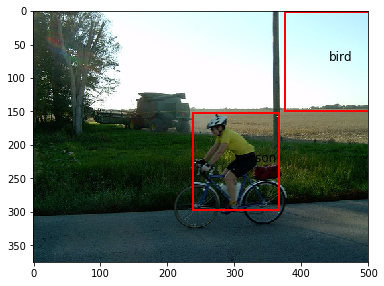

check gpos [[  0  24 314 350]
 [376 149 123 109]
 [  0 135 222 239]
 [ 65  68 159 153]
 [ 65  31 159 190]
 [264  42 235 269]
 [264  39 235 272]]


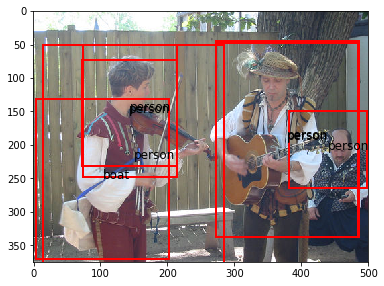

check gpos [[216 127 160 159]
 [193 134 132 116]
 [193 134 223 240]
 [306 226  80  93]
 [216 127 160 158]
 [100 127 117  98]]


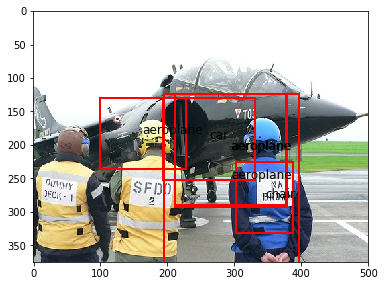

check gpos [[ 79  52 282 316]
 [120 331  78  87]
 [ 85  75 207 218]
 [298   0  76  72]
 [ 95 331 103  94]
 [ 85  75 215 237]
 [229 392  58  58]
 [ 79  82 219 238]
 [ 95 331 103  95]
 [ 95 331 126 109]
 [ 85  75 207 213]
 [ 88  75 204 213]
 [ 85  75 207 220]
 [ 53   0 321 368]
 [  0 328 135 118]]


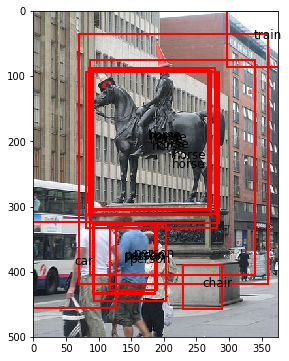

check gpos [[ 87 167  71  83]
 [354 177  62  71]
 [ 87 167  73  83]
 [ 87 167  71  82]
 [354 177  62  72]]


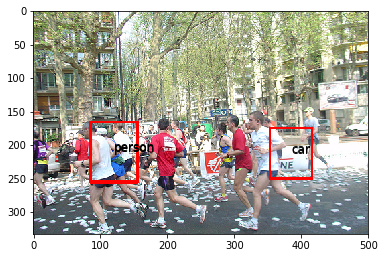

check gpos [[ 30  50  70  77]
 [  0  14 183 211]]


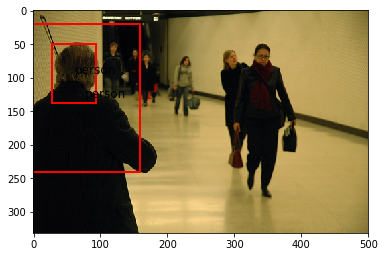

In [108]:
import matplotlib.pyplot as plt

#对val_data中的数据进行预测

def decode_label_f(encode_labels):
    '''
    根据label value获取对应具体类别
    '''
    decode_label = {}
    for label in encode_labels:
        value = encode_labels[label]
        if value > 0:#no background
            decode_label[value] = label
    
    return decode_label

regression_model = keras.models.load_model('./regression.h5')
decode_labels = decode_label_f(all_labels)#标签解析

predict_count = 0
for filepath in valdata_transform:
    
    if predict_count >5:
        break
    
    value = valdata_transform[filepath]#原始目标
    img = cv2.imread(filepath)
    proposals = region_proposal_own(img, 2000)#候选框set集合
    
    data_proposal = []#获取的proposal集合
    pos_proposal = []#用于存储pos
    for proposal in proposals:#单张图生成的proposal
        x, y, w, h = proposal

        #获取xmin, ymin, xmax, ymax
        xmin = int(x)
        ymin = int(y)
        xmax = int(x+w)
        ymax = int(y+h)

        #获取sub_img
        sub_img = img[ymin:ymax, xmin:xmax, :]
        #数据 preprocess
        sub_img = preprocess(sub_img, 224)
        data_proposal.append(sub_img)
        pos_proposal.append([x, y, w, h])
    data_proposal = np.array(data_proposal)
    pos_proposal = np.array(pos_proposal)
    
    #分类模型预测
    predict_label, feature_vector = model_transform.predict(data_proposal)
    predict_label = np.argmax(predict_label, axis = 1)
    
    #获取对象集合
    index = list(np.where(predict_label > 0)[0])
    
    if len(index)==0:#忽略无对象数据
        continue
    
    valid_predict_label = predict_label[index]
    valid_pos = pos_proposal[index]#x,y,w,h
    valid_feature = feature_vector[index]
    
    #基于提取的feature求取位置偏移量
    pos_offset = regression_model.predict(valid_feature)
    
    #根据偏移量，求取预测的的gx, gy, gw, gh
    
    gpos = valid_pos.copy()
    
    print("check gpos", gpos)
    
    gpos[:,0:2] = gpos[:,2:4] * pos_offset[:,0:2] + gpos[:,0:2]#gx, gy
    gpos[:,2:4] = gpos[:,2:4] * np.exp(pos_offset[:,2:4])
    
    #结果展示
    img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
    
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    
    for i in range(valid_predict_label.shape[0]):
        encode_label = valid_predict_label[i]
        decode_label = decode_labels[encode_label]
        x, y, w, h = gpos[i]
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        
        center_x = x + w/2
        center_y = y + h/2
        plt.text(center_x, center_y,decode_label,fontsize=12)
        
        ax.add_patch(rect)    
    
    plt.show()
    
    predict_count+=1

## 三、实验注意事项

1. 论文中采用的selective search在opencv中有接口方法，采用快速生成模式，实验结果来看，生成的框过于细碎，本实验未采用这种方式，使用自实现方法。
2. 论文基于预训练网络CNN提取的特征，训练SVM分类网络用于实现目标分类，本实验直接采用CNN的softmax方式进行目标分类。
3. 本实验fine-tune目标分类网络的正负类样本生成采用论文SVM正负类样本的生成方式。
4. 论文基于CNN提取的特征，采用ridge regression进行bounding box回归，本实验基于CNN提取的特征，直接采用Dense + tanh激活的方式进行bounding box回归。

## 四、实验拓展

1. 实验采用的backbone是ResNet50，尝试其他的fine-tune CNN网络作为backbone，测试效果
2. RCNN对于同一个proposal，多次调用CNN进行卷积计算，效率很慢，思考用什么方式可以进行优化（提示：后衍生了SPP-net）
3. 在生成bounding box回归样本时，保留的是和ground truth IOU>0.6 的proposal，可以尝试采用其他阈值，查看对结果的影响